# Poker Agent V12: Multiprocessing Training (Fixed)

**Key Features:**
1. **Multiprocessing**: True parallelism using ProcessPoolExecutor
2. **Model Sharing**: Workers use the trained model for action selection
3. **Configurable Logging**: Set LOG_PERCENT to control logging frequency
4. **Dynamic Epsilon Decay**: Automatically calculated based on total hands

### The Fix from V12 (broken)
Original V12 had workers using `random.choice()` for actions. Now workers
receive the model weights and use epsilon-greedy action selection.

In [21]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import List, Dict
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Import worker function and model from separate modules
from poker_worker import run_single_episode
from poker_model import StatisticsPokerNet

# Constants
SEED = 42
NUM_ACTIONS = 3

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


In [22]:
# ============================================
# CONFIGURABLE SETTINGS
# ============================================

# Multiprocessing
NUM_WORKERS = 6              # Number of parallel processes
EPISODES_PER_BATCH = 64      # Episodes to collect before training
EQUITY_ITERATIONS = 20       # Monte Carlo iterations for equity

# Training
BATCH_SIZE = 512             # Training batch size
BUFFER_CAPACITY = 300000     # Replay buffer size

# Logging - Set these to control output frequency
LOG_PERCENT = 2              # Log every X% of training (e.g., 1, 2, 5)
CHECKPOINT_PERCENT = 10      # Detailed checkpoint every X% (e.g., 5, 10, 20)

print(f"CPU cores: {mp.cpu_count()}, using {NUM_WORKERS} workers")
print(f"Logging every {LOG_PERCENT}%, checkpoints every {CHECKPOINT_PERCENT}%")

CPU cores: 8, using 6 workers
Logging every 2%, checkpoints every 10%


In [23]:
# ============================================
# EV-Based Reward Shaping
# ============================================

def compute_shaped_reward(final_bb_profit: float, decision_contexts: List[Dict], 
                          actions_taken: List[int]) -> float:
    """
    Compute shaped reward that distinguishes between:
    1. Losing from a mistake (had statistical edge but lost)
    2. Losing when folding was correct (good decision)
    """
    if not decision_contexts:
        return final_bb_profit
    
    reward = final_bb_profit
    ev_adjustment = 0.0
    
    for ctx, action in zip(decision_contexts, actions_taken):
        if not ctx: continue
        equity = ctx.get('equity', 0.5)
        pot_bb = ctx.get('pot_bb', 0)
        to_call_bb = ctx.get('to_call_bb', 0)
        excess_equity = ctx.get('excess_equity', 0)
        
        if action == 0:  # Fold
            if excess_equity < -0.05:  # Good fold
                ev_adjustment += 0.5 * abs(excess_equity)
            elif excess_equity > 0.1:  # Bad fold
                ev_adjustment -= 0.5 * excess_equity
        elif action == 1:  # Call
            if to_call_bb > 0:
                if excess_equity > 0.05:  # Good call
                    ev_adjustment += 0.2 * excess_equity
                elif excess_equity < -0.1:  # Bad call
                    ev_adjustment -= 0.5 * abs(excess_equity) * (pot_bb / 10.0 + 1)
        elif action == 2:  # Raise
            if equity > 0.6:  # Value bet
                ev_adjustment += 0.3 * (equity - 0.5)
            elif equity < 0.35 and final_bb_profit <= 0:  # Failed bluff
                ev_adjustment -= 0.3
    
    last_pot = decision_contexts[-1].get('pot_bb', 10) if decision_contexts else 10
    pot_importance = min(last_pot / 15.0, 3.0)
    
    if final_bb_profit > 0:
        profit_component = final_bb_profit * (1 + 0.05 * pot_importance)
    else:
        profit_component = final_bb_profit * (1 + 0.1 * pot_importance)
    
    return profit_component + ev_adjustment

In [24]:
# ============================================
# Replay Buffer & Agent
# ============================================

class ReplayBuffer:
    def __init__(self, capacity=BUFFER_CAPACITY):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, transition):
        self.buffer.append(transition)
    
    def push_batch(self, transitions):
        self.buffer.extend(transitions)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))
    
    def __len__(self):
        return len(self.buffer)


class StatisticsAgent:
    def __init__(self, state_dim=380, lr=5e-5):
        self.model = StatisticsPokerNet(state_dim).to(device)
        self.target_model = StatisticsPokerNet(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99990  # Will be recalculated dynamically
    
    def train(self, buffer, batch_size=BATCH_SIZE):
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
        actions = torch.LongTensor(np.array([t[1] for t in batch])).to(device)
        rewards = torch.FloatTensor(np.array([t[2] for t in batch])).to(device)
        next_states = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
        dones = torch.FloatTensor(np.array([t[4] for t in batch])).to(device)
        
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_actions = self.model(next_states).argmax(1).unsqueeze(1)
            target_q_next = self.target_model(next_states).gather(1, next_actions).squeeze(1)
            target = rewards + (1 - dones) * self.gamma * target_q_next
        
        loss = F.mse_loss(current_q, target)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def get_model_state_dict_cpu(self):
        """Get model state dict on CPU for multiprocessing."""
        return {k: v.cpu() for k, v in self.model.state_dict().items()}

In [25]:
# ============================================
# Parallel Training Loop with V11-Style Logging
# ============================================

def train_v12_parallel(num_hands=50000):
    """Training with process-based parallelism and V11-style logging."""
    
    agent = StatisticsAgent()
    buffer = ReplayBuffer()
    
    # Opponent tracking
    opp_names = ['ValueBot', 'BluffBot', 'Balanced']
    stats = {name: {'rewards': [], 'shaped_rewards': [], 'wins': 0, 'hands': 0} 
             for name in opp_names}
    opp_types = ['value', 'bluff', 'balanced']
    opp_name_map = {'value': 'ValueBot', 'bluff': 'BluffBot', 'balanced': 'Balanced'}
    
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts = {0: 0, 1: 0, 2: 0}
    
    start_time = time.time()
    total_hands = 0
    batch_num = 0
    
    # Calculate logging intervals based on percentages
    LOG_INTERVAL = max(100, int(num_hands * LOG_PERCENT / 100))
    CHECKPOINT_INTERVAL = max(500, int(num_hands * CHECKPOINT_PERCENT / 100))
    
    print("=" * 70)
    print(f"TRAINING V12 (Multiprocessing, {NUM_WORKERS} workers)")
    print("=" * 70)
    print(f"Total hands: {num_hands:,}")
    print(f"Episodes per batch: {EPISODES_PER_BATCH}")
    print(f"Opponent pool: {', '.join(opp_names)}")
    print()
    
    # Dynamic epsilon decay - calculated based on num_hands
    # Goal: Reach epsilon_min (0.05) at 80% of total training
    decay_steps = int(num_hands * 0.8)
    agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1 / decay_steps)
    print(f"Epsilon schedule:")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at hand {decay_steps:,} (80% of training)")
    print(f"  Decay factor: {agent.epsilon_decay:.6f}")
    print("=" * 70)
    print()
    
    # Use fork context on Linux/WSL for better performance
    try:
        ctx = mp.get_context('fork')
        print("Using 'fork' context for multiprocessing")
    except ValueError:
        ctx = mp.get_context('spawn')
        print("Using 'spawn' context for multiprocessing")
    print()
    
    last_log_hand = 0
    last_checkpoint_hand = 0
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_hands < num_hands:
            batch_num += 1
            
            # Generate batch of episode arguments with model weights
            episode_args = []
            model_state_dict = agent.get_model_state_dict_cpu()
            for i in range(EPISODES_PER_BATCH):
                seed = random.randint(0, 2**31)
                opp = random.choice(opp_types)
                episode_args.append((seed, agent.epsilon, opp, EQUITY_ITERATIONS, model_state_dict))
            
            # Run episodes in parallel
            futures = [executor.submit(run_single_episode, args) for args in episode_args]
            
            # Collect results
            batch_transitions = []
            for future in as_completed(futures):
                try:
                    result = future.result(timeout=120)
                    
                    # Compute shaped reward
                    shaped = compute_shaped_reward(
                        result['final_reward'],
                        result['contexts'],
                        result['actions']
                    )
                    
                    # Add transitions with shaped reward
                    for s, a, _, ns, d in result['transitions']:
                        batch_transitions.append((s, a, shaped, ns, d))
                    
                    # Track stats
                    opp_name = opp_name_map[result['opp_type']]
                    stats[opp_name]['rewards'].append(result['final_reward'])
                    stats[opp_name]['shaped_rewards'].append(shaped)
                    stats[opp_name]['hands'] += 1
                    if result['won']:
                        stats[opp_name]['wins'] += 1
                    
                    all_rewards.append(result['final_reward'])
                    all_shaped.append(shaped)
                    
                    for a, c in result['action_counts'].items():
                        action_counts[a] += c
                    
                    total_hands += 1
                    
                except Exception as e:
                    print(f"Episode failed: {e}")
                    continue
            
            # Add to buffer
            buffer.push_batch(batch_transitions)
            
            # Update epsilon
            for _ in range(len(batch_transitions) // 2):
                agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            
            # Training
            if len(buffer) > BATCH_SIZE * 2:
                for _ in range(4):
                    loss = agent.train(buffer)
                    if loss is not None:
                        loss_history.append(loss)
            
            if batch_num % 10 == 0:
                agent.update_target()
            
            # === LOGGING (V11 Style) ===
            if total_hands - last_log_hand >= LOG_INTERVAL:
                last_log_hand = total_hands
                elapsed = time.time() - start_time
                hands_per_sec = total_hands / elapsed if elapsed > 0 else 0
                eta_seconds = (num_hands - total_hands) / hands_per_sec if hands_per_sec > 0 else 0
                eta_min = eta_seconds / 60
                
                # Recent stats
                recent_reward = np.mean(all_rewards[-LOG_INTERVAL:]) if len(all_rewards) >= LOG_INTERVAL else np.mean(all_rewards) if all_rewards else 0
                recent_shaped = np.mean(all_shaped[-LOG_INTERVAL:]) if len(all_shaped) >= LOG_INTERVAL else np.mean(all_shaped) if all_shaped else 0
                recent_loss = np.mean(loss_history[-100:]) if loss_history else 0
                
                # Action distribution
                total_actions = sum(action_counts.values())
                fold_pct = action_counts[0] / total_actions * 100 if total_actions > 0 else 0
                call_pct = action_counts[1] / total_actions * 100 if total_actions > 0 else 0
                raise_pct = action_counts[2] / total_actions * 100 if total_actions > 0 else 0
                
                progress = total_hands / num_hands * 100
                print(f"Hand {total_hands:,}/{num_hands:,} ({progress:.1f}%) | "
                      f"Eps={agent.epsilon:.3f} | "
                      f"Avg BB: {recent_reward:+.2f} | "
                      f"Shaped: {recent_shaped:+.2f} | "
                      f"Loss: {recent_loss:.4f} | "
                      f"Speed: {hands_per_sec:.1f} h/s | "
                      f"ETA: {eta_min:.1f}m")
                print(f"        Actions: Fold {fold_pct:.1f}% | Call {call_pct:.1f}% | Raise {raise_pct:.1f}% | "
                      f"Buffer: {len(buffer):,}")
            
            # === DETAILED CHECKPOINT (V11 Style) ===
            if total_hands - last_checkpoint_hand >= CHECKPOINT_INTERVAL:
                last_checkpoint_hand = total_hands
                print()
                print(f"{'='*70}")
                print(f"CHECKPOINT: Hand {total_hands:,} / {num_hands:,} ({total_hands/num_hands*100:.1f}%)")
                print(f"{'='*70}")
                
                # Overall stats
                cumulative_bb = sum(all_rewards)
                cumulative_shaped = sum(all_shaped)
                total_wins = sum(s['wins'] for s in stats.values())
                total_hands_played = sum(s['hands'] for s in stats.values())
                win_rate = total_wins / total_hands_played if total_hands_played > 0 else 0
                
                print(f"Cumulative: {cumulative_bb:+.1f} BB (raw) | {cumulative_shaped:+.1f} (shaped)")
                print(f"Overall Win Rate: {win_rate:.1%}")
                print()
                
                # Per-opponent breakdown
                print("Per-Opponent Performance (recent 500 hands):")
                for name in opp_names:
                    if stats[name]['hands'] > 0:
                        recent = stats[name]['rewards'][-500:]
                        recent_shaped_opp = stats[name]['shaped_rewards'][-500:]
                        opp_win_rate = stats[name]['wins'] / stats[name]['hands']
                        print(f"  {name:12s}: Avg {np.mean(recent):+.2f} BB | "
                              f"Shaped {np.mean(recent_shaped_opp):+.2f} | "
                              f"Win {opp_win_rate:.1%} | "
                              f"Hands: {stats[name]['hands']:,}")
                print()
    
    # Training complete summary
    total_time = time.time() - start_time
    print()
    print("=" * 70)
    print("TRAINING COMPLETE")
    print("=" * 70)
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Average speed: {total_hands/total_time:.1f} hands/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total transitions in buffer: {len(buffer):,}")
    print(f"Cumulative reward: {sum(all_rewards):+.1f} BB")
    
    return agent, stats, all_rewards, all_shaped, loss_history

In [26]:
# ============================================
# Evaluation Function (V11 Style)
# ============================================

def evaluate_v12(agent, num_eval_hands=2000):
    """Evaluate trained agent against each opponent type."""
    from pokerkit import Automation, NoLimitTexasHoldem
    from poker_worker import monte_carlo_equity_fast, flatten_cards_list
    
    print()
    print("=" * 70)
    print("FINAL V12 EVALUATION (Epsilon=0.0)")
    print("=" * 70)
    
    starting_stack = 1000
    big_blind = 10
    small_blind = 5
    
    results = {}
    
    for opp_type in ['value', 'bluff', 'balanced']:
        opp_name = {'value': 'ValueBot', 'bluff': 'BluffBot', 'balanced': 'Balanced'}[opp_type]
        print(f"\nEvaluating vs {opp_name}...", end=" ", flush=True)
        
        rewards = []
        wins = 0
        
        for _ in range(num_eval_hands):
            state = NoLimitTexasHoldem.create_state(
                automations=(
                    Automation.ANTE_POSTING, Automation.BET_COLLECTION,
                    Automation.BLIND_OR_STRADDLE_POSTING, Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                    Automation.HAND_KILLING, Automation.CHIPS_PUSHING, Automation.CHIPS_PULLING,
                ),
                ante_trimming_status=True, raw_antes={-1: 0},
                raw_blinds_or_straddles=(small_blind, big_blind),
                min_bet=big_blind,
                raw_starting_stacks=[starting_stack, starting_stack],
                player_count=2,
            )
            while state.can_deal_hole():
                state.deal_hole()
            
            def run_automations():
                while state.can_burn_card(): state.burn_card('??')
                while state.can_deal_board(): state.deal_board()
                while state.can_push_chips(): state.push_chips()
                while state.can_pull_chips(): state.pull_chips()
            
            run_automations()
            
            ranks = '23456789TJQKA'
            suits = 'cdhs'
            
            def get_observation():
                state_vector = []
                hole = flatten_cards_list(state.hole_cards[0])
                board = flatten_cards_list(state.board_cards)
                
                for i in range(2):
                    encoding = np.zeros(52, dtype=np.float32)
                    if i < len(hole):
                        idx = ranks.index(hole[i].rank) * 4 + suits.index(hole[i].suit)
                        encoding[idx] = 1.0
                    state_vector.extend(encoding)
                
                for i in range(5):
                    encoding = np.zeros(52, dtype=np.float32)
                    if i < len(board):
                        idx = ranks.index(board[i].rank) * 4 + suits.index(board[i].suit)
                        encoding[idx] = 1.0
                    state_vector.extend(encoding)
                
                total_pot = sum(state.bets)
                current_bet = max(state.bets)
                my_bet = state.bets[0]
                to_call = current_bet - my_bet
                my_stack = state.stacks[0]
                opp_stack = state.stacks[1]
                
                equity = monte_carlo_equity_fast(hole, board, 20)
                state_vector.append(equity)
                
                pot_odds = to_call / (total_pot + to_call + 1e-6)
                state_vector.append(pot_odds)
                state_vector.append(min(to_call / (total_pot + 1e-6), 2.0))
                state_vector.append(min((my_stack / (total_pot + 1e-6)) / 20.0, 1.0))
                state_vector.append(min(my_stack, opp_stack) / starting_stack)
                state_vector.append(my_stack / starting_stack)
                state_vector.append(opp_stack / starting_stack)
                state_vector.append(total_pot / (starting_stack * 2))
                
                breakeven_equity = to_call / (total_pot + to_call + 1e-6)
                state_vector.append(breakeven_equity)
                excess_equity = equity - breakeven_equity
                state_vector.append(excess_equity)
                state_vector.append((starting_stack - my_stack) / starting_stack)
                state_vector.append(1.0 if to_call > 0 else 0.0)
                
                street = [0.0, 0.0, 0.0, 0.0]
                if len(board) == 0: street[0] = 1.0
                elif len(board) == 3: street[1] = 1.0
                elif len(board) == 4: street[2] = 1.0
                else: street[3] = 1.0
                state_vector.extend(street)
                
                return np.array(state_vector, dtype=np.float32)
            
            def get_legal_actions():
                legal = []
                if state.can_fold(): legal.append(0)
                if state.can_check_or_call(): legal.append(1)
                if state.can_complete_bet_or_raise_to(): legal.append(2)
                return legal if legal else [1]
            
            def execute_action(action):
                if action == 0:
                    if state.can_fold(): state.fold()
                    elif state.can_check_or_call(): state.check_or_call()
                elif action == 1:
                    if state.can_check_or_call(): state.check_or_call()
                    elif state.can_fold(): state.fold()
                elif action == 2:
                    if state.can_complete_bet_or_raise_to():
                        min_r = state.min_completion_betting_or_raising_to_amount
                        max_r = state.max_completion_betting_or_raising_to_amount
                        state.complete_bet_or_raise_to(min(min_r * 2, max_r))
                    elif state.can_check_or_call(): state.check_or_call()
            
            def opponent_action(legal):
                equity = monte_carlo_equity_fast(
                    flatten_cards_list(state.hole_cards[1]),
                    flatten_cards_list(state.board_cards),
                    20
                )
                
                if opp_type == 'value':
                    if equity > 0.75 and 2 in legal: return 2
                    if equity > 0.50 and 1 in legal: return 1
                    if 0 in legal: return 0
                    return 1
                elif opp_type == 'bluff':
                    if equity > 0.70 and 2 in legal: return 2
                    if equity < 0.40 and random.random() < 0.35 and 2 in legal: return 2
                    if equity > 0.45 and 1 in legal: return 1
                    if 0 in legal: return 0
                    return 1
                else:  # balanced
                    if equity > 0.80 and 2 in legal: return 2
                    if 1 in legal:
                        if equity > 0.60: return 1
                        to_call = max(state.bets) - state.bets[1]
                        pot_odds = to_call / (sum(state.bets) + to_call + 1e-5)
                        if equity > pot_odds + 0.05: return 1
                    if 0 in legal: return 0
                    return 1
            
            while state.status is not False:
                if state.actor_index == 0:  # Agent
                    obs = get_observation()
                    legal = get_legal_actions()
                    
                    # Use trained policy (no exploration)
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                        q_values = agent.model(state_tensor).squeeze(0)
                        masked_q = torch.full_like(q_values, float('-inf'))
                        for a in legal:
                            masked_q[a] = q_values[a]
                        action = masked_q.argmax().item()
                    
                    execute_action(action)
                    run_automations()
                else:  # Opponent
                    legal = get_legal_actions()
                    action = opponent_action(legal)
                    execute_action(action)
                    run_automations()
            
            final_reward = (state.stacks[0] - starting_stack) / big_blind
            rewards.append(final_reward)
            if final_reward > 0:
                wins += 1
        
        avg_bb = np.mean(rewards)
        total_bb = sum(rewards)
        win_rate = wins / num_eval_hands
        std_bb = np.std(rewards)
        
        results[opp_name] = {'avg_bb': avg_bb, 'total_bb': total_bb, 'win_rate': win_rate, 'std': std_bb}
        status = 'PROFIT' if avg_bb > 0 else 'LOSS'
        print(f"{status}")
        print(f"  Avg: {avg_bb:+.2f} BB (+/-{std_bb:.2f}) | Total: {total_bb:+.1f} BB | Win: {win_rate:.1%}")
    
    # Overall
    print()
    print("-" * 70)
    overall_avg = np.mean([r['avg_bb'] for r in results.values()])
    overall_total = sum(r['total_bb'] for r in results.values())
    print(f"OVERALL: Avg {overall_avg:+.2f} BB | Total: {overall_total:+.1f} BB")
    if overall_avg > 0:
        print("SUCCESS! Agent is profitable!")
    else:
        print("Still negative - may need more training or tuning")
    print("=" * 70)
    
    return results

In [27]:
# ============================================
# Run Training
# ============================================

# Train the agent - adjust num_hands as needed
agent, stats, all_rewards, all_shaped, loss_history = train_v12_parallel(num_hands=100000)

TRAINING V12 (Multiprocessing, 6 workers)
Total hands: 100,000
Episodes per batch: 64
Opponent pool: ValueBot, BluffBot, Balanced

Epsilon schedule:
  Start: 1.00
  Target: 0.05 at hand 80,000 (80% of training)
  Decay factor: 0.999963

Using 'fork' context for multiprocessing

Hand 2,048/100,000 (2.0%) | Eps=0.920 | Avg BB: -2.66 | Shaped: -3.47 | Loss: 1156.9364 | Speed: 44.0 h/s | ETA: 37.1m
        Actions: Fold 6.1% | Call 46.4% | Raise 47.5% | Buffer: 4,460
Hand 4,096/100,000 (4.1%) | Eps=0.846 | Avg BB: -2.03 | Shaped: -2.68 | Loss: 1129.8804 | Speed: 44.3 h/s | ETA: 36.1m
        Actions: Fold 6.7% | Call 47.5% | Raise 45.8% | Buffer: 8,945
Hand 6,144/100,000 (6.1%) | Eps=0.782 | Avg BB: -2.11 | Shaped: -2.77 | Loss: 1017.4882 | Speed: 44.4 h/s | ETA: 35.2m
        Actions: Fold 7.0% | Call 45.5% | Raise 47.5% | Buffer: 13,158
Hand 8,192/100,000 (8.2%) | Eps=0.725 | Avg BB: -2.23 | Shaped: -2.97 | Loss: 966.2127 | Speed: 44.4 h/s | ETA: 34.4m
        Actions: Fold 7.5% | Call 4

In [28]:
# ============================================
# Evaluate the Trained Agent
# ============================================

results = evaluate_v12(agent, num_eval_hands=2000)


FINAL V12 EVALUATION (Epsilon=0.0)

Evaluating vs ValueBot... PROFIT
  Avg: +0.06 BB (+/-3.42) | Total: +123.5 BB | Win: 77.1%

Evaluating vs BluffBot... LOSS
  Avg: -0.15 BB (+/-5.49) | Total: -296.5 BB | Win: 57.1%

Evaluating vs Balanced... LOSS
  Avg: -0.35 BB (+/-6.09) | Total: -695.5 BB | Win: 60.0%

----------------------------------------------------------------------
OVERALL: Avg -0.14 BB | Total: -868.5 BB
Still negative - may need more training or tuning


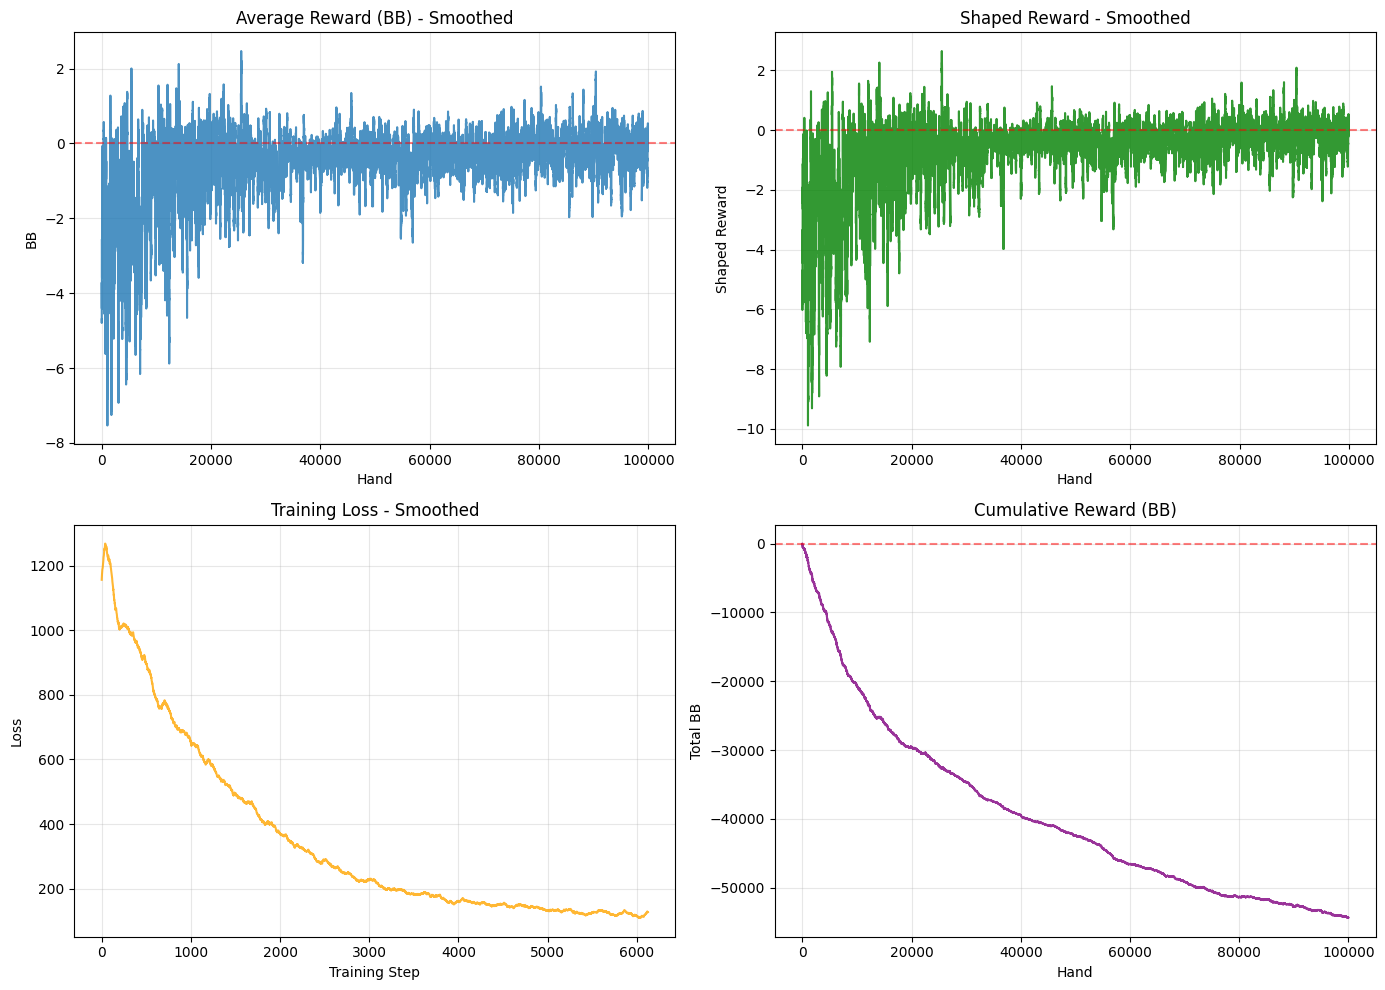


Training curves saved to poker_agent_v12_training.png


In [29]:
# ============================================
# Training Curves
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reward curve
ax1 = axes[0, 0]
window = 100
if len(all_rewards) > window:
    smoothed = np.convolve(all_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(smoothed, alpha=0.8)
else:
    ax1.plot(all_rewards, alpha=0.8)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Average Reward (BB) - Smoothed')
ax1.set_xlabel('Hand')
ax1.set_ylabel('BB')
ax1.grid(True, alpha=0.3)

# Shaped reward curve
ax2 = axes[0, 1]
if len(all_shaped) > window:
    smoothed_shaped = np.convolve(all_shaped, np.ones(window)/window, mode='valid')
    ax2.plot(smoothed_shaped, alpha=0.8, color='green')
else:
    ax2.plot(all_shaped, alpha=0.8, color='green')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Shaped Reward - Smoothed')
ax2.set_xlabel('Hand')
ax2.set_ylabel('Shaped Reward')
ax2.grid(True, alpha=0.3)

# Loss curve
ax3 = axes[1, 0]
if loss_history:
    if len(loss_history) > window:
        smoothed_loss = np.convolve(loss_history, np.ones(window)/window, mode='valid')
        ax3.plot(smoothed_loss, alpha=0.8, color='orange')
    else:
        ax3.plot(loss_history, alpha=0.8, color='orange')
ax3.set_title('Training Loss - Smoothed')
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Loss')
ax3.grid(True, alpha=0.3)

# Cumulative reward
ax4 = axes[1, 1]
cumulative = np.cumsum(all_rewards)
ax4.plot(cumulative, alpha=0.8, color='purple')
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_title('Cumulative Reward (BB)')
ax4.set_xlabel('Hand')
ax4.set_ylabel('Total BB')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('poker_agent_v12_training.png', dpi=150)
plt.show()
print("\nTraining curves saved to poker_agent_v12_training.png")

In [30]:
# ============================================
# Save Model
# ============================================

torch.save({
    'model_state_dict': agent.model.state_dict(),
    'target_model_state_dict': agent.target_model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, 'poker_agent_v12.pth')

print("Model saved to poker_agent_v12.pth")
print(f"Final epsilon: {agent.epsilon:.4f}")

Model saved to poker_agent_v12.pth
Final epsilon: 0.0500
